In [1]:
import json
import numpy as np
import pandas as pd
import os
import h5py
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X = []
y = []
with h5py.File("data/behaviours.hdf5", 'r') as ds:
    for i, key in enumerate(ds):
        print("Loading", key)
        X.append(ds[key][...])
        y.append(np.ones(ds[key].shape[0])*i)
        
        
X = np.concatenate(X, axis=0)
X[np.isnan(X)] = 0
y = np.concatenate(y, axis=0)

print(X.shape, y.shape)

Loading frontal_swings_upwards
Loading lateral_rotations_clockwise
Loading marker_up
Loading marker_up_frontal_swing
Loading marker_up_lateral_rotations
Loading marker_up_lateral_swing
Loading motor_marker_1
Loading random_motions
(92514, 13) (92514,)


In [3]:
# Pose information (= motor camera image, (x,y,z) + quaternion)
X_pose = X[:,0:3]   # only the first two components (x, y) have non-zero values
# Motor displacements
X_disp = X[:,7:13]   # last motor component is zero
X_disp[X_disp < 0] = 0

print(X_disp.shape)
print(X_pose.shape)

#X_pose[:,2] = (X_pose[:,0] + X_pose[:,1])/2 + 100 * np.random.rand(92514)

(92514, 6)
(92514, 3)


In [4]:
y = X_pose[:,0:2]
x = X_disp[:,0:5]

print(x.shape)
print(y.shape)

(92514, 5)
(92514, 2)


In [5]:
x_data = np.zeros((92514 - 10 +1,10,5))
y_data = np.zeros((92514 - 10 +1,10,2))

for i in range(92514 - 10 +1):
    x_data[i,:,:] = x[i:i+10,:]

for i in range(92514 - 10 +1):
    y_data[i,:,:] = y[i:i+10,:] 

print(x_data.shape)
print(y_data.shape)

(92505, 10, 5)
(92505, 10, 2)


In [6]:
xx = torch.randn(92514 - 10 +1, 5, 1, 10)

for i in range(92514 - 10 +1):
    for j in range(10):  
        xx[i,:,0, j] = torch.from_numpy(x_data[i,j,:])
        
#output = net(Variable(xx))
#output.data = output.data.resize_(10,2)

train_data = xx[0:90000,:,:,:]
val_data = xx[90000:92505,:,:,:]


yy = torch.randn(92514 - 10 +1, 2, 1, 10)
for i in range(92514 - 10 +1):
    for j in range(10):  
        yy[i,:,0, j] = torch.from_numpy(y_data[i,j,:])
        

train_labels = yy[0:90000,:,:,:]
val_labels = yy[90000:92505,:,:,:]


print(train_data.shape)
print(val_data.shape)
print(train_labels.shape)
print(val_labels.shape)

def num_flat_features(x):
    """
    Computes the number of features if the spatial input x is transformed
    to a 1D flat input.
    """
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

train_labels_1 = train_labels.view(-1, num_flat_features(train_labels))
print(train_labels_1.shape)

torch.Size([90000, 5, 1, 10])
torch.Size([2505, 5, 1, 10])
torch.Size([90000, 2, 1, 10])
torch.Size([2505, 2, 1, 10])
torch.Size([90000, 20])


In [7]:
from dl4cv.classifiers.classification_cnn import ClassificationCNN
from dl4cv.solver_old import Solver

#train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True, num_workers=4)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=False, num_workers=4)

model = ClassificationCNN()
solver = Solver(optim_args={"lr": 1e-3})  # overfit bcz generalisation is 0

solver.train(model, train_data, train_labels, val_data, val_labels, batch_size =50, log_nth=1, num_epochs=10)



START TRAIN.
iteration 0 / 18000: loss 68172.320312
iteration 100 / 18000: loss 43073.656250
iteration 200 / 18000: loss 27160.082031
iteration 300 / 18000: loss 25880.468750
iteration 400 / 18000: loss 22754.578125
iteration 500 / 18000: loss 24456.427734
iteration 600 / 18000: loss 24363.925781
iteration 700 / 18000: loss 28768.546875
iteration 800 / 18000: loss 24623.488281
iteration 900 / 18000: loss 23692.185547
iteration 1000 / 18000: loss 23827.238281
iteration 1100 / 18000: loss 25049.115234
iteration 1200 / 18000: loss 21837.414062
iteration 1300 / 18000: loss 21262.416016
iteration 1400 / 18000: loss 20559.732422
iteration 1500 / 18000: loss 22056.998047
iteration 1600 / 18000: loss 22628.082031
iteration 1700 / 18000: loss 21313.240234
iteration 1800 / 18000: loss 22690.550781
iteration 1900 / 18000: loss 20161.996094
iteration 2000 / 18000: loss 21328.585938
iteration 2100 / 18000: loss 20892.162109
iteration 2200 / 18000: loss 22757.248047
iteration 2300 / 18000: loss 2272

KeyboardInterrupt: 

TypeError: Invalid dimensions for image data

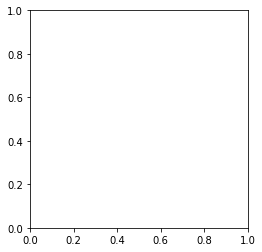

In [8]:
# visualising filters


from dl4cv.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()